# Base code for GAT

In [1]:
# import packages and reading in files:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv
import torch.nn.functional as F
import matplotlib.pyplot as plt

# import python files needed to create adjacency matrices
import reading_data

In [2]:
adjacency_matrix, mapping_index_to_node, mapping_entity_to_index = reading_data.create_adjacency_matrix_nt("data/aifb/aifb+.nt", literal_representation="filtered", sparse=True)
number_nodes = adjacency_matrix.size()[0]

# add the file names
file_name_train = "data/aifb/gz_files/aifb+_train_set.nt.gz"
file_name_valid = "data/aifb/gz_files/aifb+_valid_set.nt.gz"
file_name_test = "data/aifb/gz_files/aifb+_test_set.nt.gz"

labels, train_entities, valid_entities, test_entities = reading_data.training_valid_test_set(file_name_train, file_name_valid, file_name_test, mapping_entity_to_index, adjacency_matrix.size()[0])
train_mask = torch.tensor([i in train_entities for i in range(len(labels))])
valid_mask = torch.tensor([i in valid_entities for i in range(len(labels))])
test_mask = torch.tensor([i in test_entities for i in range(len(labels))])

#feature_matrix = torch.sparse_coo_tensor(indices=torch.tensor([list(range(number_nodes)), list(range(number_nodes))]), values=torch.ones(number_nodes),size=(number_nodes, number_nodes))
feature_matrix = torch.rand(size=(number_nodes, 100)) # using 100 features

# add training and test mask, add labels list

data_aifb = Data(x=feature_matrix, edge_index=adjacency_matrix.coalesce().indices(), num_nodes=number_nodes, y=labels.long(), train_mask=train_mask, test_mask=test_mask)

In [3]:
data_aifb

Data(x=[2835, 100], edge_index=[2, 20338], y=[2835], num_nodes=2835, train_mask=[2835], test_mask=[2835])

In [4]:
data_aifb.x

tensor([[0.4693, 0.2860, 0.1337,  ..., 0.7886, 0.4196, 0.4930],
        [0.0115, 0.7947, 0.1485,  ..., 0.2490, 0.1901, 0.1796],
        [0.6771, 0.8669, 0.4234,  ..., 0.9704, 0.3503, 0.0271],
        ...,
        [0.7736, 0.5106, 0.8596,  ..., 0.2568, 0.8841, 0.8980],
        [0.7571, 0.1782, 0.8597,  ..., 0.4952, 0.6743, 0.7093],
        [0.4114, 0.3979, 0.9990,  ..., 0.4347, 0.3377, 0.1831]])

In [5]:
nr_labels = len(labels.unique())

In [6]:
import torch
from torch_geometric.nn import GATConv
import torch.nn.functional as F
from torch.nn import Dropout


class GAT(torch.nn.Module):
    """
    Implementation of the Graph Attention Network.
    Based on paper <add reference to paper>
    """

    def __init__(self, input_nodes, hidden_nodes, output_nodes, nr_heads, dropout):
        """
        Intializes the GAT model, using the GATConv layers of PyTorch Geometric.
        :param input_nodes: The number of input nodes of the GAT model.
        :param hidden_nodes: The number of hidden nodes of the GAT model.
        :param output_nodes: The number of output nodes of the GAT model.
        :param nr_heads: The number of heads of the first GAT layer.
        :param dropout: The probability of dropout during the training phase. Note that the dropour probability is the
        same for every layer, for both the attention coefficients and the input.
        """
        super().__init__()
        # dropout is applied to the GAT convolutional layer as well, as described in the paper
        self.layer1 = GATConv(input_nodes, hidden_nodes, heads=nr_heads, dropout=dropout)

        # need to put heads to 1, to be able to get output
        self.layer2 = GATConv(nr_heads * hidden_nodes, output_nodes, heads=1, dropout=dropout)

        # use the same probability for everything
        self.dropout = Dropout(p=dropout)

    def forward(self, X, A):
        """
        Performs one forward pass of the initialized GAT model.
        :param X: The feature matrix.
        :param A: The adjacency matrix in COO format.
        :return: The embeddings the GAT model produces.
        """
        # in the paper, they use dropout on both of the layers' input while training
        X = self.dropout(X)
        h1 = self.layer1(X, A)

        # in the paper they use an exponential linear unit, which is used here as well:
        h1_activated = F.elu(h1)
        h1_activated = self.dropout(h1_activated)
        
        h2 = self.layer2(h1_activated, A)
        # cross entropy loss used, therefore a softmax is not needed.
        return h2

In [7]:
# now, create a training loop:
from torch.nn import CrossEntropyLoss

model = GAT(data_aifb.num_features, 16, output_nodes=nr_labels, nr_heads=8, dropout=0.6)
loss_function = CrossEntropyLoss()
optimizer = optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [8]:
nr_epochs = 200
loss_list = list()

for i in range(nr_epochs):
    model.train()
    optimizer.zero_grad()
    
    output = model(data_aifb.x, data_aifb.edge_index)
    loss = loss_function(output[train_mask], data_aifb.y[train_mask])
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())

In [9]:
loss_list

[2.6146888732910156,
 2.0664970874786377,
 2.747476577758789,
 1.819443702697754,
 1.843961477279663,
 1.9100803136825562,
 1.5919140577316284,
 1.920763373374939,
 2.256671190261841,
 1.935688853263855,
 1.7454086542129517,
 1.8675661087036133,
 1.793034553527832,
 1.8689281940460205,
 1.6661059856414795,
 1.3375952243804932,
 1.550525426864624,
 1.5260587930679321,
 1.4102967977523804,
 1.8533380031585693,
 1.3837947845458984,
 1.458461046218872,
 1.4257339239120483,
 1.5411813259124756,
 1.4278727769851685,
 1.3572005033493042,
 1.4499690532684326,
 1.5931603908538818,
 1.33726966381073,
 1.4945718050003052,
 1.4511781930923462,
 1.3448753356933594,
 1.39395010471344,
 1.3527650833129883,
 1.353955864906311,
 1.217560887336731,
 1.4116092920303345,
 1.265128493309021,
 1.2731459140777588,
 1.3028618097305298,
 1.269993543624878,
 1.4857761859893799,
 1.3439475297927856,
 1.330613136291504,
 1.4160292148590088,
 1.331817865371704,
 1.375675082206726,
 1.2326347827911377,
 1.355224728

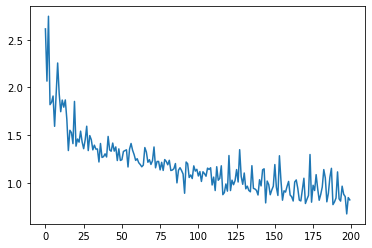

In [11]:
plt.plot(loss_list)